#Car Price Prediction with Machine Learning

In [71]:
!pip install shap
!pip install xgboost

##Importing Libraries

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

## Load the dataset

In [73]:
df = pd.read_csv('car data.csv')

## Initial Exploration

In [74]:
print("Dataset Head:\n", df.head())

Dataset Head:
   Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  


In [75]:
print("\nDataset Info:\n")
df.info()


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [76]:
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
               Year  Selling_Price  Present_Price     Driven_kms       Owner
count   301.000000     301.000000     301.000000     301.000000  301.000000
mean   2013.627907       4.661296       7.628472   36947.205980    0.043189
std       2.891554       5.082812       8.642584   38886.883882    0.247915
min    2003.000000       0.100000       0.320000     500.000000    0.000000
25%    2012.000000       0.900000       1.200000   15000.000000    0.000000
50%    2014.000000       3.600000       6.400000   32000.000000    0.000000
75%    2016.000000       6.000000       9.900000   48767.000000    0.000000
max    2018.000000      35.000000      92.600000  500000.000000    3.000000


## Handling Missing Values

In [77]:

if df.isnull().sum().sum() > 0:
    print("\nMissing Values:\n", df.isnull().sum())
    df = df.dropna()  # Drop rows with missing values

## Feature Engineering

In [78]:
# Create a new feature 'Car_Age'
current_year = 2025
df['Car_Age'] = current_year - df['Year']
df.drop(['Year', 'Car_Name'], axis=1, inplace=True)  # Drop unnecessary columns

## Exploratory Data Analysis (EDA)

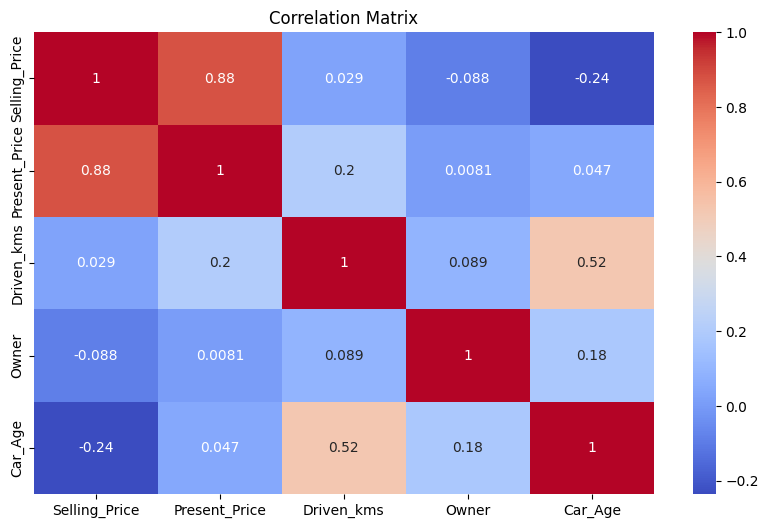

In [79]:

plt.figure(figsize=(10, 6))
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns  # Select only numerical columns
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

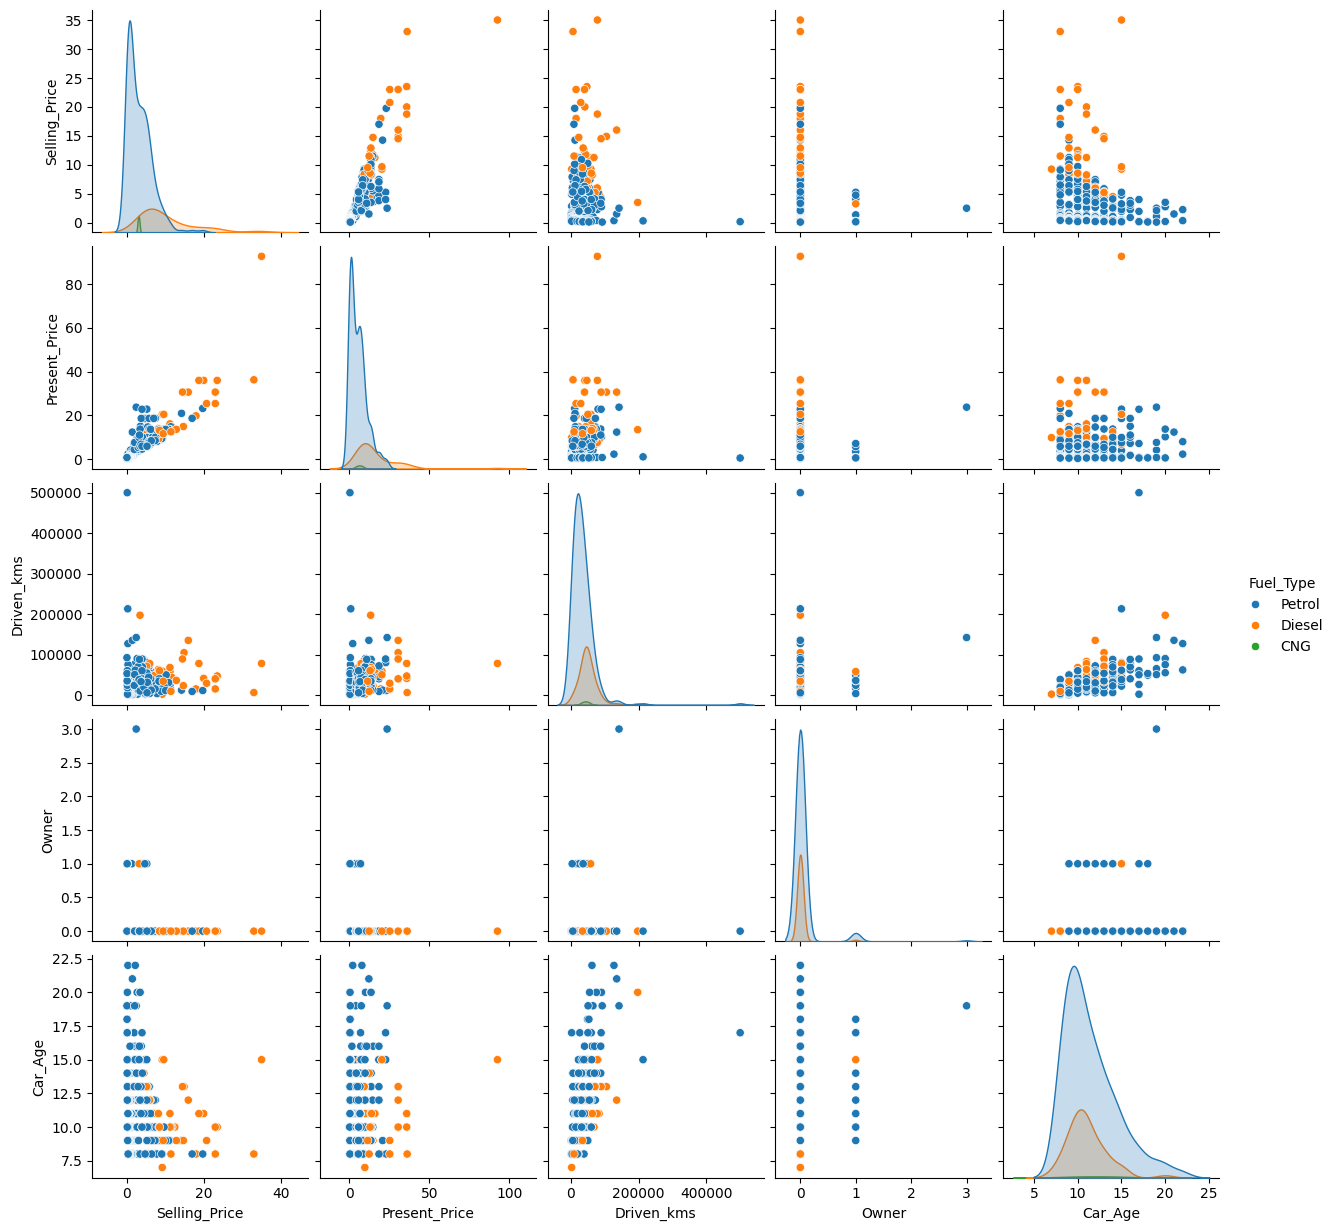

In [80]:
sns.pairplot(df, diag_kind='kde', hue='Fuel_Type', vars=numerical_cols)
plt.show()

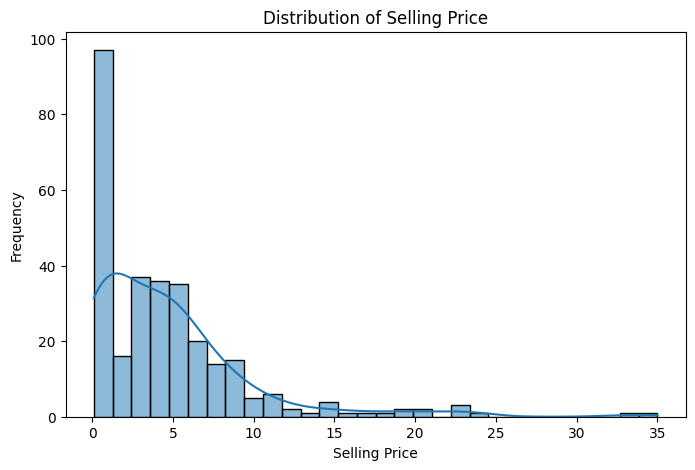

In [81]:
# Distribution of Selling Price
plt.figure(figsize=(8, 5))
sns.histplot(df['Selling_Price'], kde=True, bins=30)
plt.title("Distribution of Selling Price")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.show()

## Splitting Features and Target

In [82]:

X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

## Define categorical and numerical columns

In [83]:

categorical_features = ['Fuel_Type', 'Selling_type', 'Transmission']
numerical_features = ['Present_Price', 'Driven_kms', 'Car_Age', 'Owner']

## Preprocessing

In [84]:

categorical_transformer = OneHotEncoder(drop='first')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Applying models

In [85]:

linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

random_forest_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [86]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# Preprocess the data for XGBoost manually
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [88]:
# Train and evaluate Linear Regression
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
print("Linear Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred_linear))
print("R2 Score:", r2_score(y_test, y_pred_linear))

Linear Regression Results:
MSE: 3.481349830511856
R2 Score: 0.8488707839193137


In [89]:
# Train and evaluate Random Forest Regressor
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
print("\nRandom Forest Results:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))


Random Forest Results:
MSE: 0.8770054303278679
R2 Score: 0.9619282319684407


In [90]:
# Train and evaluate XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)
y_pred_xgb = xgb_model.predict(X_test_preprocessed)
print("\nXGBoost Results:")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("R2 Score:", r2_score(y_test, y_pred_xgb))


XGBoost Results:
MSE: 1.0955931588543528
R2 Score: 0.9524390988260215


### Hyperparameter Tuning for Random Forest

In [91]:

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(random_forest_model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("\nBest Parameters for Random Forest:", grid_search.best_params_)


Best Parameters for Random Forest: {'regressor__max_depth': 10, 'regressor__n_estimators': 300}


## Shap Explainability

In [92]:
# Explainability with SHAP for XGBoost
explainer = shap.Explainer(xgb_model, X_train_preprocessed)
shap_values = explainer(X_test_preprocessed)

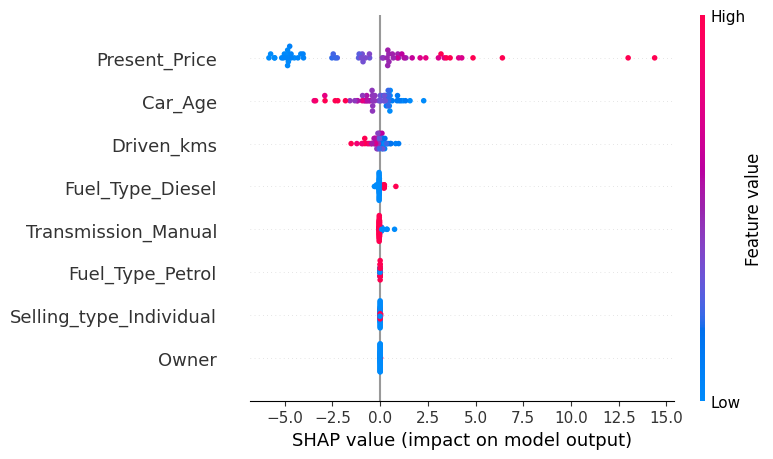

In [93]:
# SHAP Summary Plot
shap.summary_plot(shap_values, feature_names=numerical_features + preprocessor.transformers_[1][1].get_feature_names_out().tolist())

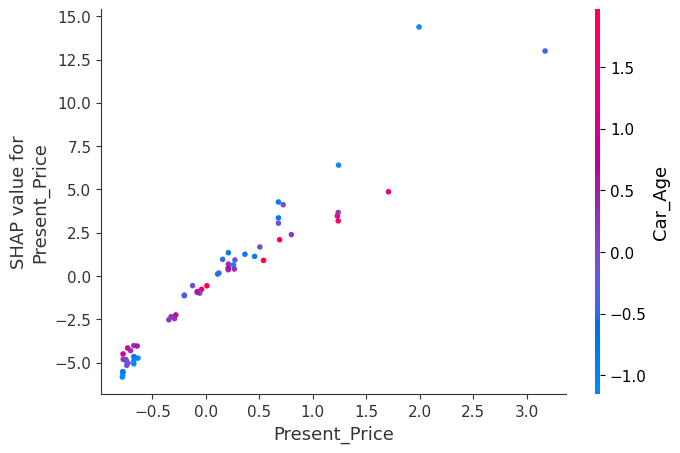

In [94]:
# SHAP Dependence Plot for 'Present_Price'
shap.dependence_plot('Present_Price', shap_values.values, X_test_preprocessed,
                     feature_names=numerical_features + preprocessor.transformers_[1][1].get_feature_names_out().tolist())
